In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import math
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Preparation of the LoS tables
## Saves price and accessibility attribute to PT LoS table
## Needs PT LoS table and links

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
los = stepmodel.read_json(model_path + scenario + '/' + 'de_pt_los')
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [9]:
los.pt_los.drop([col for col in los.pt_los.columns if col.startswith('(')], axis=1, inplace=True)

In [10]:
if 'route_type_network' in los.pt_los.columns:
    los.pt_los['route_type'] = los.pt_los['route_type_network']
    if los.pt_los['route_type'].isna().max():
        # Add main route_type based on a hierarchy
        hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
        def main_type(types):
            t = hierarchy[-1]
            try:
                t = hierarchy[min([hierarchy.index(t) for t in types])]
            except ValueError: # empty types set
                pass
            return t
        los.pt_los['route_type'] = los.pt_los['route_types'].apply(main_type)

In [11]:
# Make sure time is converted to seconds
if los.pt_los['time'].mean() < 10:
    los.pt_los['time'] = los.pt_los['time'] * 3600
los.pt_los['time'].mean()

21081.97900408736

In [12]:
sm.links.sample(2)

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway
index,,,,,,,,,,
bus_1052972,bus,bus,"LINESTRING (9.89764 47.90879, 9.89002 47.90779)",b_DE148_6,b_DE148_582,1,bus_16814,780,bus_16814_1,21600
bus_1087053,bus,bus,"LINESTRING (10.28693 48.55807, 10.38572 48.55695)",b_DE11C_96,b_DE277_8,1,bus_17022,60,bus_17022_42,43200


In [13]:
# Add P&R LoS table, if available
'''if os.path.exists(model_path + scenario + '/de_pr_los/'):
    pr = stepmodel.read_json(model_path + scenario + '/de_pr_los')
    sm.pt_los = pd.concat([los.pt_los, pr.pr_los])
else:'''
sm.pt_los = los.pt_los

In [14]:
# Get demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

## Prices

First, we apply distance-dependent cost factors on links. Then, we apply the intercepts and further assumptions on pt_los

In [16]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)

In [17]:
# Initialise segment-specific price columns
for seg in segments:
    sm.links[seg+'_price'] = 0

In [18]:
type_dict = sm.links['route_type'].to_dict()

In [19]:
# Apply link cost for rail_short
rail_short_slope = params['rail_short']['slope']
mask = sm.links['route_type']=='rail_short'
for seg in segments:
    sm.links.loc[mask, seg+'_price'] = sm.links.loc[mask, 'length'] / 1000 * rail_short_slope

In [20]:
# Apply link cost for rail_long
# There are two different parameters for time and distance slope, respectively
# The segment-specific savings share weights the pricing regimes that were bought
dist_slope_reg = params['rail_long']['dist_slope_regular']
dist_slope_sav = params['rail_long']['dist_slope_savings']
time_slope_reg = params['rail_long']['time_slope_regular']
time_slope_sav = params['rail_long']['time_slope_savings']
mask = sm.links['route_type']=='rail_long'
for seg in segments:
    savings_share = params['rail_long']['savings_share_'+seg]
    sm.links.loc[mask, seg+'_price'] = [
        d/1000 * (dist_slope_sav * savings_share + dist_slope_reg * (1-savings_share))
        + t/3600 * (time_slope_sav * savings_share + time_slope_reg * (1-savings_share))
        for d,t in zip(sm.links.loc[mask, 'length'], sm.links.loc[mask, 'time'])]

In [21]:
# Apply link cost for coach
mask = sm.links['route_type']=='coach'
for seg in segments:
    sm.links.loc[mask, seg+'_price'] = \
        sm.links.loc[mask, 'length'] / 1000 * params['coach']['slope']

In [48]:
# Sum link cost
for seg in segments:
    price_dict = sm.links[seg+'_price'].to_dict()
    sm.pt_los[seg+'_price'] = sm.pt_los['link_path'].apply(
        lambda l: sum([price_dict[link] for link in l]))

### Rail short-distance
Short-distance rail services have the price structure stated in the DB document. However, most people who use it have some kind of abonement and don't buy single trip tickets. cal10 shows that for trips under 50km distance there is a 50% share of permanent abonements. Moreover, it doesn't make sense to choose short-distance rail services on long distances. Still, if so, people choose the "Quer-durchs-Land-Ticket" for 42€.

y=0.233*x+1.468


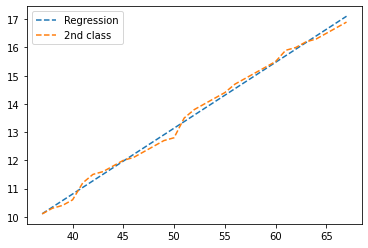

In [23]:
# Use second class single trip prices
# Choose a fit for a distance range up to 60 km (longer links are rare)
if manual:
    c = pd.read_csv(input_path + 'level_of_service/DB_2020_preisliste_fahrplanjahr_2020.csv')
    z = np.polyfit(c.loc[0:30, 'km'], c.loc[0:30, 'single_trip_second_class'], deg=1)
    p = np.poly1d(z)
    plt.plot(c.loc[0:30, 'km'], p(c.loc[0:30, 'km']), linestyle='--', marker=' ', label='Regression')
    plt.plot(c.loc[0:30, 'km'], c.loc[0:30, 'single_trip_second_class'], linestyle='--', marker=' ', label='2nd class')
    plt.legend()
    print('y={}*x+{}'.format(np.round(z[0], 3), np.round(z[1], 3)))

In [62]:
# Add rail short intercept
mask = sm.pt_los['route_type']=='rail_short'
for seg in segments:
    sm.pt_los.loc[mask, seg+'_price'] += params['rail_short']['intercept']

In [63]:
# Add a price floor for short-distance rail (and cap for consistency)
for seg in segments:
    sm.pt_los.loc[mask, seg+'_price'] = np.clip(
        sm.pt_los.loc[mask, seg+'_price'],
        params['rail_short']['min'],
        params['rail_short']['max'])

In [64]:
# Add abonements share for short-distance rail
for seg in segments:
    sm.pt_los.loc[mask, seg+'_price'] *= params['rail_short']['reduction_share_'+seg]

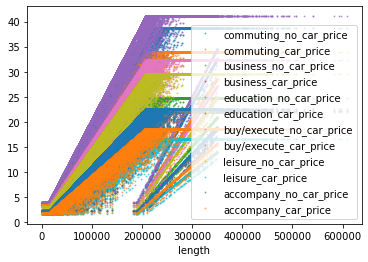

In [65]:
if manual:
    sm.pt_los.loc[mask].set_index('length')[[s+'_price' for s in segments]].plot(
        kind='line', linestyle=' ', marker='o', markersize=1, alpha=.5)

### Rail long distance

Long-distance services have a complicated price structure that is not published by DB. Thus, we need to make assumptions based on a regression analysis of observation data (see prep32):

* Rail transport is purely path-distance and -duration-dependent
* Price dependency is linear
* There is a price cap of 139 EUR
* Assume a distribution of Sparpreis and Flexpreis

In [66]:
# Add an intercept
mask = sm.pt_los['route_type']=='rail_long'
for seg in segments:
    savings_share = params['rail_long']['savings_share_'+seg]
    sm.pt_los.loc[mask, seg+'_price'] += \
        params['rail_long']['intercept_regular'] * (1-savings_share) + \
        params['rail_long']['intercept_savings'] * savings_share

In [67]:
# Add a price cap and floor for long-distance rail
for seg in segments:
    sm.pt_los.loc[mask, seg+'_price'] = np.clip(
        sm.pt_los.loc[mask, seg+'_price'],
        params['rail_long']['min'],
        params['rail_long']['max'])

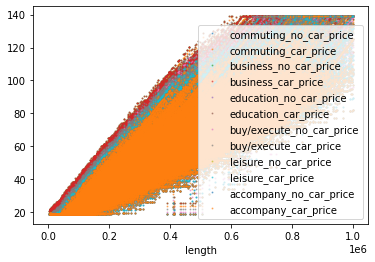

In [68]:
if manual:
    sm.pt_los.loc[mask].set_index('length')[[s+'_price' for s in segments]].plot(
        kind='line', linestyle=' ', marker='o', markersize=1, alpha=.5)

### Coach

Assume a linear cost function based on distance. There are several sample studies available:
* Average cost in Germany (0.107 EUR/pkm): https://de.statista.com/statistik/daten/studie/380601/umfrage/kilometerpreise-fernbuslinien-in-deutschland/
* Average cost on selected OD pairs with cheapest prices: https://www.fernbusse.de/aktuelles/studie-fernbuspreise-steigen-leicht-bahntickets-guenstiger-1628/

The latter is more realistic

In [69]:
# Add a price cap and floor
mask = sm.pt_los['route_type']=='coach'
for seg in segments:
    sm.pt_los.loc[mask, seg+'_price'] = np.clip(
        sm.pt_los.loc[mask, seg+'_price'],
        params['coach']['min'],
        params['coach']['max'])

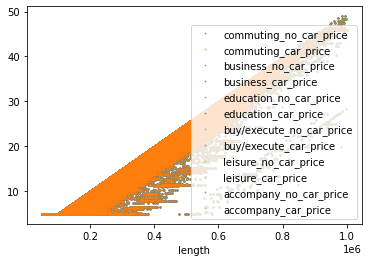

In [70]:
if manual:
    sm.pt_los.loc[mask].set_index('length')[[s+'_price' for s in segments]].plot(
        kind='line', linestyle=' ', marker='o', markersize=1, alpha=.5)

### Air


<AxesSubplot:xlabel='time'>

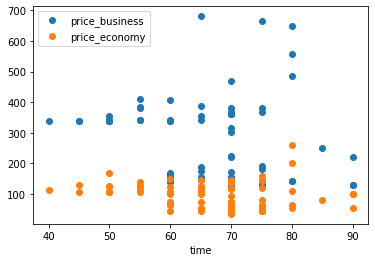

In [71]:
# Load connection list
air = pd.read_excel(input_path + 'public_transport/air_connections_germany.xls', engine='xlrd')
air = air.loc[air['direct']==True]
air['a'] = air['origin'].str[:3]
air['b'] = air['destination'].str[:3]
#print('Average economy price: {} EUR'.format(air['price_economy'].mean()))
#print('Average business price: {} EUR'.format(air['price_business'].mean()))
air[['price_business', 'price_economy', 'time']].set_index('time').plot(linestyle=' ', marker='o')

In [72]:
# Take the economy price because its share is higher
# than 90% within Germany
air['trip'] = air['a'] + '-' + air['b']
air_price_dict = air.set_index('trip')['price_economy'].to_dict()
air_prices = sm.links.loc[sm.links['route_type']=='air', 'trip_id'].map(
    air_price_dict).fillna(params['air']['default']).to_dict()

In [73]:
# Add air prices to path cost
mask = sm.pt_los['route_type']=='air'
for seg in segments:
    sm.pt_los.loc[mask, seg+'_price'] += sm.pt_los.loc[mask, 'link_path'].apply(
        lambda l: sum([air_prices[link] if link in air_prices.keys() else 0
                       for link in l]))
    
    # Add intercepts of rail modes
    sm.pt_los.loc[(mask) & (sm.pt_los['route_types'].apply(lambda l: 'rail_short' in l)),
                  seg+'_price'] += params['rail_short']['intercept']
    savings_share = params['rail_long']['savings_share_'+seg]
    sm.pt_los.loc[(mask) & (sm.pt_los['route_types'].apply(lambda l: 'rail_long' in l)),
                  seg+'_price'] += \
        params['rail_long']['intercept_regular'] * (1-savings_share) + \
        params['rail_long']['intercept_savings'] * savings_share
    
    print(sm.pt_los.loc[mask, seg+'_price'].mean())

114.5926726383747
115.87823713244285
116.30675863046555
116.30675863046555
114.16415114035134
114.16415114035134
115.02119413639633
115.44971563442051
114.16415114035134
114.5926726383747
114.16415114035134
114.16415114035134


In [74]:
assert len(sm.pt_los.loc[sm.pt_los[[s+'_price' for s in segments]].isna().any(axis=1)])==0

### Local transport

Local transport fares are added on top, as they are usually included into the rail ticket price or have a standalone price map dependent on ordinal distance classes.

In [75]:
# Add a fare for local transport services
# Get links with bus service at start or end of the trip
mode_dict = sm.links['route_type'].to_dict()
bus_at_o = sm.pt_los['link_path'].apply(lambda l: mode_dict[l[0]]=='bus' if len(l)>0 else False)
bus_at_d = sm.pt_los['link_path'].apply(lambda l: mode_dict[l[-1]]=='bus' if len(l)>0 else False)
only_bus = sm.pt_los['route_type']=='bus'
# Bus tickets are included in long-distance rail tickets
rail_long = sm.pt_los['route_types'].apply(lambda t: 'rail_long' in t)
# Define price structure by regional type
region_dict = sm.zones['urbanisation'].to_dict()
region_prices = params['bus'].to_dict()
first_last_mile_discount_factor = params['bus']['multimodal_share']

for seg in segments:
    # Case 1: Multimodal
    sm.pt_los.loc[(bus_at_o) & ~(only_bus) & ~(rail_long), seg+'_price'] += sm.pt_los.loc[
        (bus_at_o) & ~(only_bus) & ~(rail_long), 'origin'].map(region_dict).map(region_prices) \
            * first_last_mile_discount_factor
    sm.pt_los.loc[(bus_at_d) & ~(only_bus) & ~(rail_long), seg+'_price'] += sm.pt_los.loc[
        (bus_at_d) & ~(only_bus) & ~(rail_long), 'destination'].map(region_dict).map(region_prices) \
            * first_last_mile_discount_factor

    # Case 2: Only bus (take the higher urbanisation degree from O and D)
    sm.pt_los.loc[only_bus, seg+'_price'] = [
        region_prices[min(region_dict[o], region_dict[d])]
        for o,d in zip(sm.pt_los.loc[only_bus, 'origin'], sm.pt_los.loc[only_bus, 'destination'])]

In [76]:
assert len(sm.pt_los.loc[sm.pt_los[[s+'_price' for s in segments]].isna().any(axis=1)])==0

## Save

In [77]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,business_no_car_price,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price
index,,,,,,,,,,,,,,,,,,,,,
216924,DE40C,DEB3C,"[rail_long, rail_short]","[rs_58576, rs_58577, rs_58578, rs_58579, rs_58...",2,553378,2185,66,19404,2200,...,102.505905,102.505905,77.129279,77.129279,87.27993,92.355255,77.129279,82.204605,77.129279,77.129279


In [78]:
sm.to_json(model_path + scenario + '/' + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:08<00:00,  4.16it/s]
